# load raw radar data

In [1]:
import zipfile
import os
import re
from functools import cmp_to_key
from datetime import datetime, timedelta
from PIL import Image
import json
import random
# import pickle
import webdataset as wds
import numpy as np
from tqdm import tqdm
import pandas as pd
import time
import uuid

# Basic configurations

In [2]:
data_dir = "data/zuimei-radar"

# Remove corrupted zip files, need be run for only once

In [3]:
def remove_corrupted_zips(directory):
    # Collect all ZIP files
    zip_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                zip_files.append(file_path)
    
    # Process each ZIP file with a progress bar
    for file_path in tqdm(zip_files, desc="Checking ZIP files"):
        try:
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                # Check if the ZIP file is complete
                bad_file = zip_file.testzip()
                if bad_file:
                    os.remove(file_path)
                    print(f"Warning: '{file_path}' is a corrupted ZIP file, removed.")
                    
        except zipfile.BadZipFile:
            os.remove(file_path)
            print(f"Warning: '{file_path}' is not a valid ZIP file, removed.")

In [4]:
# remove_corrupted_zips(data_dir)

# Read files and sort in time

In [5]:
def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                    
    return file_paths

def sort_key(file_path):
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if match:
        return int(match.group(1))
    else:
        return float('inf')

In [6]:
# Example usage
file_paths = get_file_paths(data_dir)
print(f"number of files: {len(file_paths)}")
print("before sort: \n", file_paths[:5])

file_paths.sort(key=cmp_to_key(lambda x, y: (sort_key(x) > sort_key(y)) - (sort_key(x) < sort_key(y))))

print("after sort: \n", file_paths[:5])

number of files: 28417
before sort: 
 ['data/zuimei-radar/20230117/Z_RADA_C_BABJ_20230117085900_P_ACHN.QREF000.20230117.085400.latlon.zip', 'data/zuimei-radar/20230117/Z_RADA_C_BABJ_20230117022305_P_ACHN.QREF000.20230117.021800.latlon.zip', 'data/zuimei-radar/20230117/Z_RADA_C_BABJ_20230117141105_P_ACHN.QREF000.20230117.140600.latlon.zip', 'data/zuimei-radar/20230117/Z_RADA_C_BABJ_20230117204702_P_ACHN.QREF000.20230117.204200.latlon.zip', 'data/zuimei-radar/20230117/Z_RADA_C_BABJ_20230117024105_P_ACHN.QREF000.20230117.023600.latlon.zip']
after sort: 
 ['data/zuimei-radar/20230101/Z_RADA_C_BABJ_20230101000504_P_ACHN.QREF000.20230101.000000.latlon.zip', 'data/zuimei-radar/20230101/Z_RADA_C_BABJ_20230101001103_P_ACHN.QREF000.20230101.000600.latlon.zip', 'data/zuimei-radar/20230101/Z_RADA_C_BABJ_20230101001703_P_ACHN.QREF000.20230101.001200.latlon.zip', 'data/zuimei-radar/20230101/Z_RADA_C_BABJ_20230101002302_P_ACHN.QREF000.20230101.001800.latlon.zip', 'data/zuimei-radar/20230101/Z_RADA_C_

# Split the files into time consecutive periods, time interval is 6 minutes

In [7]:
# get consecutive time periods
def get_time_from_path(file_path, return_type='datetime'):
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if match:
        time_str = match.group(1)
        if return_type == 'datetime':
            return datetime.strptime(time_str, '%Y%m%d%H%M%S')
        else:
            return time_str
    else:
        return None

times = [get_time_from_path(path) for path in file_paths]
times.sort()

periods = []
current_period = []
time_interval = 360
delta = 5

for i in range(len(times)):
    current_time = times[i]
    if i == 0 or (times[i] - times[i - 1]).total_seconds() >= time_interval - delta and (times[i] - times[i - 1]).total_seconds() <= time_interval + delta:
        current_period.append(file_paths[i])
    else:
        periods.append(current_period)
        current_period = [file_paths[i]]

if current_period:
    periods.append(current_period)

print(f"Length of periods of consecutive file paths: {len(periods)}")
# for period in periods[:5]:
#     print(period)
count = sum([1 for period in periods if len(period)>=24])
lens = [len(period) for period in periods if len(period)>=0]
print(f"Number of periods with length>=24: {count}")
print(f"Lengths of all periods: {lens}")

Length of periods of consecutive file paths: 177
Number of periods with length>=24: 38
Lengths of all periods: [193, 55, 341, 203, 205, 794, 622, 515, 707, 714, 1, 3394, 1634, 1134, 761, 1140, 10, 175, 731, 197, 759, 66, 4770, 734, 3, 2, 1334, 18, 4, 4, 14, 4, 29, 4, 9, 14, 8, 14, 4, 4, 4, 4, 4, 9, 4, 4, 14, 4, 9, 4, 9, 4, 14, 14, 4, 49, 4, 9, 9, 9, 14, 24, 4, 4, 4, 19, 14, 9, 4, 4, 14, 4, 4, 34, 4, 12, 6, 14, 9, 9, 3, 4, 9, 4, 14, 4, 4, 4, 4, 4, 4, 19, 4, 14, 9, 9, 9, 14, 19, 4, 4, 4, 14, 9, 9, 9, 9, 29, 4, 4, 4, 4, 9, 4, 19, 4, 9, 14, 14, 14, 14, 4, 4, 4, 4, 4, 4, 4, 14, 4, 9, 19, 14, 14, 4, 4, 9, 14, 14, 14, 14, 14, 4, 4, 39, 4, 4, 14, 4, 9, 9, 3642, 35, 1, 127, 1, 519, 1, 153, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 632, 293, 59, 572]


# Test reading a radar frame

In [8]:
def read_data(file_path):
    # Open the ZIP file
    with zipfile.ZipFile(file_path, 'r') as zip_file:
        # Get the name of the file inside the ZIP archive
        file_name = zip_file.namelist()[0]

        # Open the file inside the ZIP archive
        with zip_file.open(file_name) as file:
            # Load the NumPy array from the file
            data = np.loadtxt(file)
    
    return data

# Print the loaded NumPy array
data = read_data(file_paths[0])
print(f"data type: {type(data)}, data shape: {data.shape}")

data type: <class 'numpy.ndarray'>, data shape: (4200, 6200)


# Analyze the data

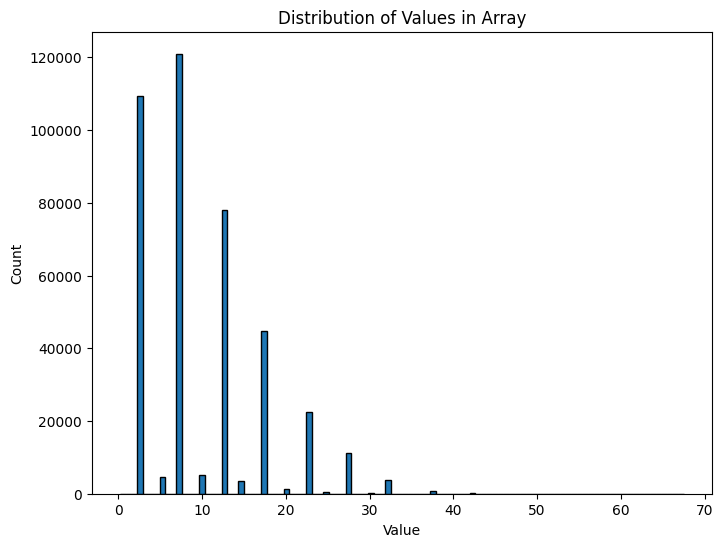

In [9]:
import matplotlib.pyplot as plt

data = data[~np.isnan(data)]
data = data[data>0]

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(data, bins=100, edgecolor='black')
plt.title('Distribution of Values in Array')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [9]:
import datetime
import os

import cartopy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import shapely.geometry as sgeom
import tensorflow as tf
# import tensorflow_hub

import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

matplotlib.rc('animation', html='jshtml')

def plot_radar_image(radar_image, vmin=0, vmax=75):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the data as an image
    im = ax.imshow(radar_image, vmin=vmin, vmax=vmax, cmap='jet')  # viridis 

    # Add a colorbar beside the figure
    cbar = fig.colorbar(im, ax=ax, shrink=1)

    # Add a label to the colorbar
    cbar.set_label('Radar signal strength (dbz)', rotation=270, labelpad=20)
    # plt.imshow(cropped_frames[0, ...], vmin=0, vmax=10, cmap='jet')
    plt.show()

    
def plot_image_with_boxes(image, valid_positions, vmin=0, vmax=75, crop_size=256):
    # Create a larger figure
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(1, 2, width_ratios=[50, 1])  # Allocate space for image and color bar

    # Plot the radar image
    ax0 = plt.subplot(gs[0])
    cax = plt.subplot(gs[1])
    im = ax0.imshow(image, vmin=vmin, vmax=vmax, cmap='jet')
    fig.colorbar(im, cax=cax, label='Radar signal strength (dbz)')

    # Create a rectangle patch for each valid position
    for row, col, count in valid_positions:
        # Create a rectangle
        rect = patches.Rectangle((col, row), crop_size, crop_size, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax0.add_patch(rect)
        # Add the count text to the center of the rectangle
        ax0.text(col + crop_size/2, row + crop_size/2, str(count), color='white', ha='center', va='center', fontsize=8)

    # Display the plot
    plt.show()
    
    
def plot_animation(field, figsize=None, vmin=0, vmax=10, cmap="jet", **imshow_args):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    ax.set_axis_off()
    plt.close() # Prevents extra axes being plotted below animation
    img = ax.imshow(field[0, ..., 0], vmin=vmin, vmax=vmax, cmap=cmap, **imshow_args)

    def animate(i):
        img.set_data(field[i, ..., 0])
        return (img,)

    return animation.FuncAnimation(
      fig, animate, frames=field.shape[0], interval=24, blit=False)


class ExtendedOSGB(cartopy.crs.OSGB):
    """MET office radar data uses OSGB36 with an extended bounding box."""

    def __init__(self):
        super().__init__(approx=False)

    @property
    def x_limits(self):
        return (-405000, 1320000)

    @property
    def y_limits(self):
        return (-625000, 1550000)
    
    @property
    def boundary(self):
        x0, x1 = self.x_limits
        y0, y1 = self.y_limits
        return sgeom.LinearRing([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])


def plot_rows_on_map(rows, field_name="radar_frames", timestep=0, num_rows=None,
                     cbar_label=None, **imshow_kwargs):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    if num_rows is None:
        num_rows = next(iter(rows.values())).shape[0]
    for b in range(num_rows):
        extent = (rows["osgb_extent_left"][b].numpy(),
                  rows["osgb_extent_right"][b].numpy(),
                  rows["osgb_extent_bottom"][b].numpy(),
                  rows["osgb_extent_top"][b].numpy())
        im = axes.imshow(rows[field_name][b, timestep, ..., 0].numpy(),
                    extent=extent, **imshow_kwargs)

    axes.set_xlim(*axes.projection.x_limits)
    axes.set_ylim(*axes.projection.y_limits)
    axes.set_facecolor("black")
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="white")
    if cbar_label:
        cbar = fig.colorbar(im)
        cbar.set_label(cbar_label)
    return fig


def plot_animation_on_map(row):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    plt.close() # Prevents extra axes being plotted below animation

    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="white")

    extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

    img = axes.imshow(
      row["radar_frames"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=15., cmap="jet")

    cbar = fig.colorbar(img)
    cbar.set_label("Precipitation, mm/hr")

    def animate(i):
        return img.set_data(row["radar_frames"][i, ..., 0].numpy()),

    return animation.FuncAnimation(
      fig, animate, frames=row["radar_frames"].shape[0],
      interval=24, blit=False)


def plot_mask_on_map(row):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="black")

    extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

    img = axes.imshow(
      row["radar_mask"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=1, cmap="viridis")

2024-05-15 05:24:24.617578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 05:24:31.816323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## for each consecutive periods with length >= 24, prepeare examples

In [11]:
import numpy as np
from tqdm import tqdm
import time

def read_data(file_path):
    # Open the ZIP file
    with zipfile.ZipFile(file_path, 'r') as zip_file:
        # Get the name of the file inside the ZIP archive
        file_name = zip_file.namelist()[0]

        # Open the file inside the ZIP archive
        with zip_file.open(file_name) as file:
            # Load the NumPy array from the file
            data = np.loadtxt(file)
    
    return data


def read_frames(file_paths, vmin=0, vmax=75):
    
    frames = []
    for file_path in file_paths:
        try:
            data = read_data(file_path)
            frames.append(data)
        except Exception as e:
            print(f"{e}: {file_path}")
    
    frames = np.stack(frames, axis=0)
    frames[np.isnan(frames)] = 0
    frames[frames>vmax] = vmax
    frames[frames<vmin] = vmin
    frames = frames.astype(np.float32)
    
    return frames


# def compute_integral_image(image):
#     """Compute the integral image of a given image."""
#     integral_image = np.zeros_like(image)
#     rows, cols = image.shape
    
#     # Compute the integral image
#     for i in range(rows):
#         for j in range(cols):
#             integral_image[i, j] = 1 if image[i, j] > 0 else 0
#             if i > 0:
#                 integral_image[i, j] += integral_image[i-1, j]
#             if j > 0:
#                 integral_image[i, j] += integral_image[i, j-1]
#             if i > 0 and j > 0:
#                 integral_image[i, j] -= integral_image[i-1, j-1]
                
#     return integral_image


# def get_window_sum(integral_image, top_left, bottom_right):
#     """Compute the sum of pixel values in a window using the integral image."""
#     top, left = top_left
#     bottom, right = bottom_right
    
#     window_sum = integral_image[bottom, right]
#     if top > 0:
#         window_sum -= integral_image[top-1, right]
#     if left > 0:
#         window_sum -= integral_image[bottom, left-1]
#     if top > 0 and left > 0:
#         window_sum += integral_image[top-1, left-1]
        
#     return window_sum


# def crop_image(image, crop_size=256, num_thr=50):
#     # Compute the integral image
#     integral_image = compute_integral_image(image)
    
#     # Get the dimensions of the image
#     rows, cols = image.shape
    
#     # Initialize variables to keep track of the maximum non-zero count and its position
#     max_count = -1
#     max_pos = (0, 0)
    
#     valid_positions = []
#     # Slide the window across the integral image
#     for i in range(0, rows - crop_size + 1):
#         for j in range(0, cols - crop_size + 1):
#             # Compute the sum of pixel values in the current window
#             count = get_window_sum(integral_image, (i, j), (i+crop_size-1, j+crop_size-1))
            
#             # Update the maximum count and its position if the current count is greater
#             if count > max_count:
#                 max_count = count
#                 max_pos = (i, j)
            
#             if count > num_thr:
#                 valid_positions.append((i, j))
    
#     # Crop the image using the position with the maximum count
#     cropped_image_max_nonzero = image[max_pos[0]:max_pos[0]+crop_size, max_pos[1]:max_pos[1]+crop_size]
    
#     # If no valid position found, raise an exception
#     if not valid_positions:
#         raise ValueError("No valid crop position found with the given threshold.")

#     # Select a random valid position
#     random_idx = np.random.choice(len(valid_positions))
#     random_pos = valid_positions[random_idx]

#     # Crop the array
#     cropped_image_random = image[random_pos[0]:random_pos[0]+crop_size,
#                          random_pos[1]:random_pos[1]+crop_size]

#     result = {
#         "cropped_image_max_nonzero": cropped_image_max_nonzero,
#         "max_pos": max_pos,
#         "cropped_image_random": cropped_image_random,
#         "random_pos": random_pos,
#         "valid_positions": valid_positions
#     }
    
#     return result

def pad_image(arr, base_num=32):

    # Calculate the padding needed for each dimension
    pad_dim1 = (base_num - arr.shape[0] % base_num) % base_num
    pad_dim2 = (base_num - arr.shape[1] % base_num) % base_num

    # Calculate the padding amount for each side
    pad_width = ((0, pad_dim1), (0, pad_dim2))

    # Pad the array with zeros
    padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
    padded_arr = padded_arr.astype(np.float32)

    # print("Padded array shape:", padded_arr.shape)
    
    return padded_arr

def crop_image_grid(image, crop_size=256, num_thr=1000, threshold=5):
    # cropping the image by dividing the frame into grids
    
    
    print(f"original image shape: {image.shape}")
    padded_image = pad_image(image, crop_size)
    
    width, height = padded_image.shape
    print(f"padded image shape: {padded_image.shape}")
    
    counts = []
    valid_positions = []
    for row in tqdm(range(0, width, crop_size)):
        for col in range(0, height, crop_size):
            cropped_image = padded_image[row:row+crop_size, col:col+crop_size]
            count = np.sum(cropped_image>=threshold)
            if count >= num_thr:
                valid_positions.append((row, col, count))
                counts.append(count)
    
    return {"valid_positions": valid_positions}


# def crop_frames(frames, crop_size=256, num_thr=100):
#     # used to crop the large frame into small frames
#     result = crop_image(frames[0], crop_size=crop_size, num_thr=num_thr)
    
#     max_pos = result['max_pos']
#     cropped_frames_max_nonzero = frames[:,max_pos[0]:max_pos[0]+crop_size, max_pos[1]+max_pos[1]+crop_size]
    
#     random_pos = result['random_pos']
#     cropped_frames_random= frames[:,random_pos[0]:random_pos[0]+crop_size, random_pos[1]+random_pos[1]+crop_size]
    
#     cropped_result = {
#         "cropped_frames_max_nonzero": cropped_frames_max_nonzero,
#         "max_pos": max_pos,
#         "cropped_frames_random": cropped_frames_random,
#         "random_pos": random_pos
#     }
    
#     return cropped_result

In [12]:
period_frames = read_frames(periods[0][:24])

In [13]:
period_frames.shape

(24, 4200, 6200)

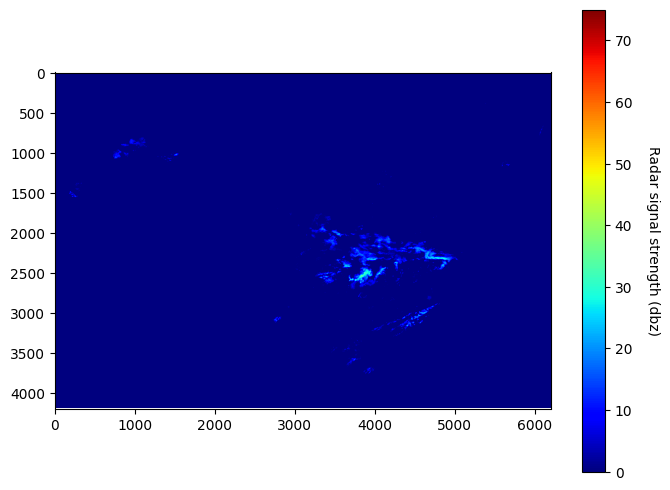

In [14]:
plot_radar_image(period_frames[0], vmin=0, vmax=75)

In [15]:
chosen_frame = period_frames[0]
crop_result = crop_image_grid(chosen_frame, crop_size=256, num_thr=1000, threshold=10)
print(crop_result)
print(len(crop_result['valid_positions']))

original image shape: (4200, 6200)
padded image shape: (4352, 6400)


100%|██████████| 17/17 [00:00<00:00, 535.94it/s]

{'valid_positions': [(768, 768, 2581), (1024, 768, 1057), (1024, 1280, 1007), (1792, 3072, 1078), (1792, 3328, 6347), (1792, 3584, 1141), (2048, 3328, 7326), (2048, 3584, 7868), (2048, 3840, 11826), (2048, 4096, 8080), (2048, 4352, 9592), (2048, 4608, 8530), (2304, 3328, 4524), (2304, 3584, 10744), (2304, 3840, 25348), (2304, 4096, 6327), (2304, 4352, 1161), (2304, 4608, 12431), (2304, 4864, 4812), (2560, 3328, 3891), (2560, 3584, 8590), (2560, 3840, 3780), (2816, 4352, 4549), (2816, 4608, 2542), (3072, 2560, 1190), (3072, 4096, 1703), (3072, 4352, 4722)]}
27


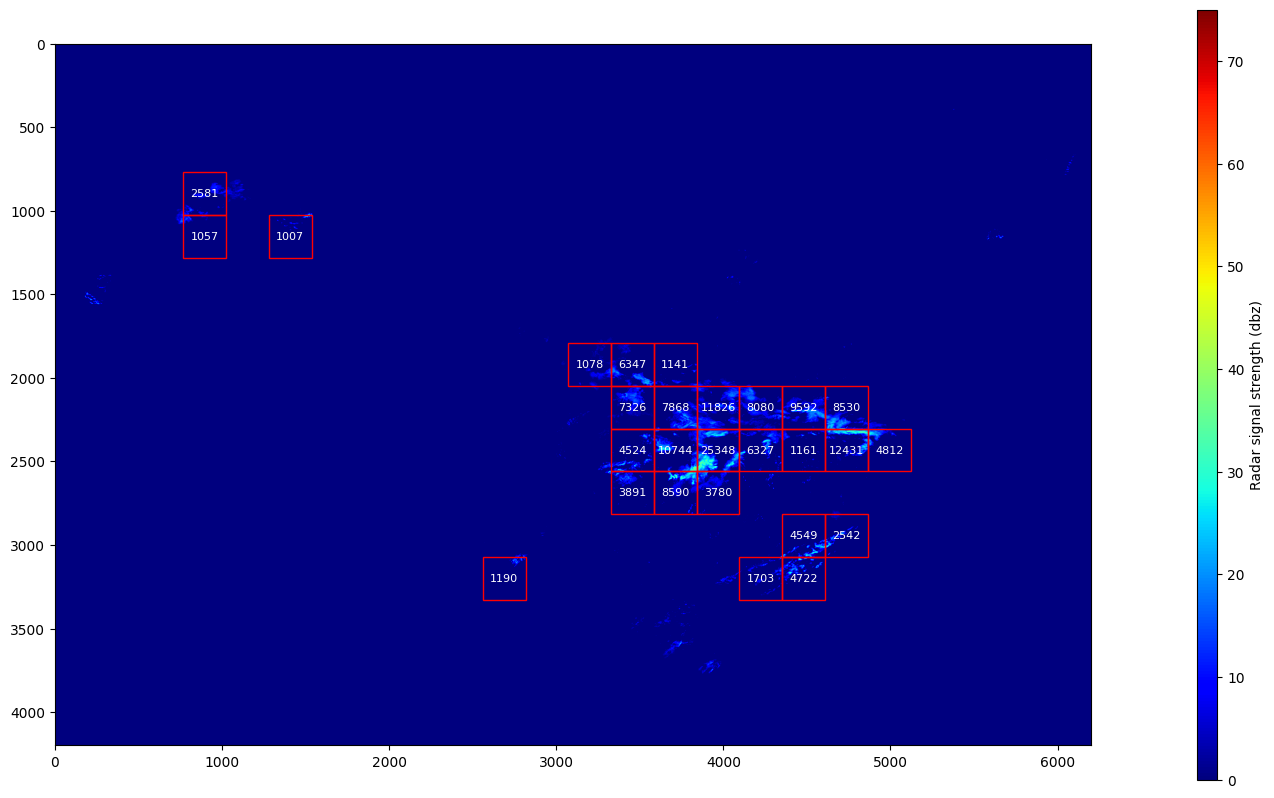

In [16]:
plot_image_with_boxes(chosen_frame, crop_result['valid_positions'])

In [17]:
# examples = []

# crop_size = 256
# num_thr = 1000 # for random cropping, ensure that the cropped area has at least this number of elements are nonzero
# threshold = 10

# num_periods = 5
# num_total_frames = 24

# for period in tqdm(periods[:num_periods]):
#     if len(period) < num_total_frames:
#         continue
    
#     start_reading = time.time()
#     print(f"Start reading {len(period)} frames ...")
#     period_frames = read_frames(period)
#     end_reading = time.time()
#     time_cost_reading = end_reading - start_reading
#     print(f"End reading {len(period)} frames, time cost: {time_cost_reading:.2f}s.")
    
#     freq_update_crop_region = 240 # change crop regions every 24 hours, 240 * 6 min
    
#     frame_result = {"valid_positions": [(0, 0, 0)]}
    
#     print("Start croppping")
#     num_examples = len(period)-num_total_frames+1
#     for idx in tqdm(range(num_examples)):
#         frames = period_frames[idx:idx+num_total_frames]
        
#         if idx % freq_update_crop_region == 0:
#             frame_result = crop_image_grid(frames[0], crop_size, num_thr, threshold)
        
#         # max_pos = frame_result['max_pos']
#         # cropped_frames_max_nonzero = frames[:,max_pos[0]:max_pos[0]+crop_size, max_pos[1]:max_pos[1]+crop_size]

#         # random_idx = np.random.choice(len(frame_result["valid_positions"]))
#         # random_pos = frame_result["valid_positions"][random_idx]
        
#         valid_positions = frame_result["valid_positions"]
#         for position in valid_positions:
#             cropped_frames = frames[:,position[0]:position[0]+crop_size, position[1]:position[1]+crop_size]

#             frame_start_time = get_time_from_path(period[idx], 'str')

#             cropped_result = {
#                 "cropped_frames": cropped_frames,
#                 "position": position,
#                 "start_time": frame_start_time
#             }
        
#             examples.append(cropped_result)
    
#     end_crop = time.time()
#     time_cost_crop = end_crop - end_reading
#     print(f"End cropping {num_examples} frames, time cost: {time_cost_crop}s, average time cost: {time_cost_crop/num_examples:.2f}s")

# Process data and save the data

In [18]:
crop_size = 256
num_thr = 1000 # for random cropping, ensure that the cropped area has at least this number of elements are nonzero
threshold = 10

num_periods = 1
num_total_frames = 24

count = 0
tar_id = 0
num_per_tar = 20

save_dir = f"data/zuimei-radar-cropped-num_thr{num_thr}-threshold{threshold}"
os.makedirs(save_dir, exist_ok=True)

for period in tqdm(periods[:num_periods]):
    if len(period) < num_total_frames:
        continue
            
    sub_period_size = 60  # 24 * 60 / 6 = 240 one day, 6 hours = 
    
    for sub_pid in range(0, len(period), sub_period_size):
        start_reading = time.time()
        sub_period = period[sub_pid:sub_pid+sub_period_size]
        print(f"Start reading {len(sub_period)} frames ...")
        period_frames = read_frames(sub_period)
        end_reading = time.time()
        time_cost_reading = end_reading - start_reading
        print(f"End reading {len(sub_period)} frames, time cost: {time_cost_reading:.2f}s.")

        print("Start croppping and saving")
        try:
            frame_result = crop_image_grid(period_frames[0], crop_size, num_thr, threshold)
        except Exception as e:
            print(f"Error: {e}")
            continue
        
        num_examples = period_frames.shape[0] - num_total_frames + 1
        
        valid_positions = frame_result['valid_positions']
        for idx in tqdm(range(num_examples)):
            frames = period_frames[idx:idx+num_total_frames]
            
            for position in valid_positions:
                cropped_frames= frames[:,position[0]:position[0]+crop_size, position[1]:position[1]+crop_size]

                frame_start_time = get_time_from_path(period[idx], 'str')

                # Define the output dataset directory
                if count == 0:
                    output_dir = os.path.join(save_dir, f"{tar_id:06d}.tar")
                    writer = wds.TarWriter(output_dir)

                sample = {
                    "__key__": str(uuid.uuid4()),
                    "cropped_frames": cropped_frames.tobytes(),
                    "position": np.array(position, dtype=np.float32).tobytes(),
                    "start_time": frame_start_time.encode(),
                }

                # Write the sample to the dataset
                writer.write(sample)
                count += 1

                if count == num_per_tar:
                    # Close the writer
                    writer.close()
                    count = 0
                    tar_id += 1
    
        end_crop = time.time()
        time_cost_crop = end_crop - end_reading
        print(f"End cropping and saving {num_examples} frames, time cost: {time_cost_crop}s, average time cost: {time_cost_crop/num_examples:.2f}s")

if count < num_per_tar:
    writer.close()

  0%|          | 0/1 [00:00<?, ?it/s]

Start reading 60 frames ...
End reading 60 frames, time cost: 137.77s.
Start croppping and saving
original image shape: (4200, 6200)
padded image shape: (4352, 6400)



100%|██████████| 17/17 [00:00<00:00, 540.65it/s]

100%|██████████| 37/37 [00:35<00:00,  1.06it/s]


End cropping and saving 37 frames, time cost: 35.074124813079834s, average time cost: 0.95s
Start reading 60 frames ...
End reading 60 frames, time cost: 144.68s.
Start croppping and saving
original image shape: (4200, 6200)
padded image shape: (4352, 6400)



100%|██████████| 17/17 [00:00<00:00, 539.86it/s]

100%|██████████| 37/37 [00:28<00:00,  1.31it/s]


End cropping and saving 37 frames, time cost: 28.329640865325928s, average time cost: 0.77s
Start reading 60 frames ...
End reading 60 frames, time cost: 144.64s.
Start croppping and saving
original image shape: (4200, 6200)
padded image shape: (4352, 6400)



100%|██████████| 17/17 [00:00<00:00, 529.68it/s]

100%|██████████| 37/37 [00:33<00:00,  1.12it/s]


End cropping and saving 37 frames, time cost: 33.18427753448486s, average time cost: 0.90s
Start reading 13 frames ...
End reading 13 frames, time cost: 30.04s.
Start croppping and saving
original image shape: (4200, 6200)
padded image shape: (4352, 6400)



100%|██████████| 17/17 [00:00<00:00, 544.82it/s]

0it [00:00, ?it/s]
100%|██████████| 1/1 [09:13<00:00, 553.80s/it]

End cropping and saving -10 frames, time cost: 0.06885600090026855s, average time cost: -0.01s


# Test loading the stored frames

In [1]:
import random
import torch
import os
import numpy as np

num_input = 4
num_target = 20

def revert_back_numpy_array(byte_array, size=(24, 256, 256), dtype=np.float32, source_dtype=np.float32):
    # Load the flattened data from disk
    flattened_data = bytearray(byte_array) 
    flattened_array = np.frombuffer(flattened_data, dtype=source_dtype)
    # Reshape the flattened array to the original shape
    original_array = flattened_array.reshape(size).astype(dtype)
    
    return original_array


class MyCollator(object):
    def __init__(self, num_input_frames, num_forecast_frames):
        self.num_input_frames = num_input_frames
        self.num_forecast_frames = num_forecast_frames
        
    def __call__(self, examples):
        # do something with batch and self.params
        inputs, targets = [], []
        for i, example in enumerate(examples):
            cropped_frames = revert_back_numpy_array(example["cropped_frames"], size=(24, 256, 256), dtype=np.float32)
            position = revert_back_numpy_array(example["position"], size=(3), dtype=np.uint8, source_dtype=np.float32)

            input_frames = cropped_frames[:self.num_input_frames, ...]
            target_frames = cropped_frames[self.num_input_frames:self.num_input_frames+self.num_forecast_frames, ...]
        
            inputs.append(input_frames)
            targets.append(target_frames)

        inputs_tensor = torch.Tensor(np.stack(inputs)).unsqueeze(2)
        targets_tensor = torch.Tensor(np.stack(targets)).unsqueeze(2)

        return inputs_tensor, targets_tensor

In [2]:
import os
from datasets import load_dataset

test_data_dir = "./data/zuimei-radar-cropped-num_thr1000_threshold10/"
# test_data_dir = "./data/zuimei-radar-cropped-debug/train"
# test_data_dir = "./data/zuimei-radar-cropped/train"
# test_data_dir = "./data/zuimei-radar-cropped-num_thr6000"
test_data_dir = "./data/zuimei-radar-cropped-num_thr1000-threshold10-test"

test_dataset = load_dataset("webdataset", 
                    data_files={"test": os.path.join(test_data_dir,"00000*.tar")}, 
                    split="test", 
                    streaming=True)

/home/ec2-user/SageMaker/efs/conda_envs/dgmr_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 1

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        shuffle=False,
        collate_fn=MyCollator(num_input, num_target),
        batch_size=batch_size,
        num_workers=1,
    )

In [4]:
from collections import defaultdict
import tarfile

def count_distinct_files(folder_path):
    # distinct_files = defaultdict(set)
    # for filename in os.listdir(folder_path):
    #     if filename.endswith('.tar'):
    #         tar_path = os.path.join(folder_path, filename)
    #         with tarfile.open(tar_path, 'r') as tar:
    #             for member in tar.getmembers():
    #                 if member.isfile():
    #                     file_name = os.path.basename(member.name)
    #                     file_prefix, _ = os.path.splitext(file_name)
    #                     distinct_files[file_prefix].add(file_name)
    # return len(distinct_files)

    filenames = [filename for filename in os.listdir(folder_path) if filename.endswith('.tar')]
    
    return len(filenames) * 20  # 20 examples per tar file

In [5]:
test_data_len = count_distinct_files(test_data_dir)
test_loader_len = test_data_len // batch_size
print(f"Number of test examples: {test_data_len}")
print(f"Number of batches: {test_loader_len}")

Number of test examples: 105360
Number of batches: 105360


In [20]:
from tqdm import tqdm

for step, batch in tqdm(enumerate(test_dataloader), total=test_loader_len):
    if step >= 1000:
        break
    # print(batch)
    
print(batch[0].shape, batch[1].shape)

  0%|          | 200/105360 [00:03<34:29, 50.81it/s]

torch.Size([1, 4, 1, 256, 256]) torch.Size([1, 20, 1, 256, 256])


In [21]:
input_frames = batch[0]
target_frames = batch[1]
print(input_frames.shape, target_frames.shape)

torch.Size([1, 4, 1, 256, 256]) torch.Size([1, 20, 1, 256, 256])


In [22]:
plot_animation(torch.cat([input_frames, target_frames], dim=1).squeeze().unsqueeze(-1), figsize=(8, 5), vmin=0, vmax=75)